This Data Science problem focuses on analyzing wildlife strikes, particularly bird strikes, to find their impact on aircraft safety, financial costs, and other disruptions. The goal is to explore trends in these striked, and analyze the factors such as flight phase, aircraft type, location, etc. By leveraging statistical analysis, visualization, and predictive modeling, we aim to provide key insights from our analyses that will answer the problem provided in this dataset.


#### Clean the data



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression

bird_df = pd.read_csv('Bird_Strikes_1990_2023.csv')

# inspection of data
print(bird_df.shape)
print(bird_df.dtypes)
print(bird_df.isnull().sum())
bird_df.info()

C:\Users\33628\AppData\Local\Temp\ipykernel_29268\1017686449.py:6: DtypeWarning: Columns (18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  bird_df = pd.read_csv('Bird_Strikes_1990_2023.csv')


(288810, 100)
INDEX_NR           int64
INCIDENT_DATE     object
INCIDENT_MONTH     int64
INCIDENT_YEAR      int64
TIME              object
                   ...  
REPORTED_TITLE    object
SOURCE            object
PERSON            object
LUPDATE           object
TRANSFER            bool
Length: 100, dtype: object
INDEX_NR               0
INCIDENT_DATE          0
INCIDENT_MONTH         0
INCIDENT_YEAR          0
TIME              125177
                   ...  
REPORTED_TITLE         0
SOURCE                 0
PERSON             21134
LUPDATE                0
TRANSFER               0
Length: 100, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288810 entries, 0 to 288809
Data columns (total 100 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   INDEX_NR               288810 non-null  int64  
 1   INCIDENT_DATE          288810 non-null  object 
 2   INCIDENT_MONTH         288810 non-null  int64  
 3   I

In [2]:
# 1. Convert 'INCIDENT_DATE' to datetime
bird_df['INCIDENT_DATE'] = pd.to_datetime(bird_df['INCIDENT_DATE'], errors='coerce')

# 2. Fill missing values in categorical columns with 'Unknown'
categorical_cols = ['TIME_OF_DAY', 'AIRPORT_ID', 'AIRPORT', 'STATE', 'FAAREGION', 'OPERATOR', 'PHASE_OF_FLIGHT', 'SPECIES', 'DAMAGE_LEVEL']
bird_df[categorical_cols] = bird_df[categorical_cols].fillna('Unknown')

# 3. Convert COST_REPAIRS and COST_OTHER to numeric before filling missing values
bird_df['COST_REPAIRS'] = pd.to_numeric(bird_df['COST_REPAIRS'], errors='coerce')
bird_df['COST_OTHER'] = pd.to_numeric(bird_df['COST_OTHER'], errors='coerce')

# 4. Fill missing values in numerical columns with median values
numerical_cols = ['HEIGHT', 'SPEED', 'COST_REPAIRS', 'COST_OTHER']
for col in numerical_cols:
    bird_df[col] = bird_df[col].fillna(bird_df[col].median())

# 5. Convert categorical fields to 'category' type
categorical_convert = ['TIME_OF_DAY', 'AIRPORT_ID', 'STATE', 'PHASE_OF_FLIGHT', 'DAMAGE_LEVEL', 'FAAREGION']
for col in categorical_convert:
    bird_df[col] = bird_df[col].astype('category')

# 6. Remove duplicates
bird_df.drop_duplicates(inplace=True)

# 7. Remove unrealistic values (e.g., negative or zero HEIGHT & SPEED)
bird_df = bird_df[(bird_df['HEIGHT'] > 0) & (bird_df['SPEED'] > 0)]

# 8. Create a new column ‘TOTAL_COST’ summing ‘COST_REPAIRS’ and ‘COST_OTHER’
bird_df['TOTAL_COST'] = bird_df[['COST_REPAIRS', 'COST_OTHER']].fillna(0).sum(axis=1)

# 9. Create 'YEAR_MONTH' column 
bird_df['YEAR_MONTH'] = bird_df['INCIDENT_YEAR'].astype(str) + "-" + bird_df['INCIDENT_MONTH'].astype(str).str.zfill(2)

In [3]:
# Summary statistics for 3 continuous variables
continuous_vars = ['HEIGHT', 'SPEED', 'TOTAL_COST']
print("\nContinuous Variables:")
print(bird_df[continuous_vars].describe())

# Summary statistics for 3 categorical variables
categorical_vars = ['DAMAGE_LEVEL', 'PHASE_OF_FLIGHT', 'TIME_OF_DAY']
print("\nCategorical Variables:")
for col in categorical_vars:
    print(f"\n{col}:\n", bird_df[col].value_counts())

bird_df.info()
print("\nFirst 5 Rows:")
bird_df.head()
print("\nSummary Statistics:")
print(bird_df.describe())



Continuous Variables:
              HEIGHT          SPEED     TOTAL_COST
count  225510.000000  225510.000000  225510.000000
mean      602.461589     144.349723     580.491814
std      1541.102725      26.338894      23.188776
min         1.000000       1.000000      50.000000
25%        50.000000     140.000000     580.000000
50%        50.000000     140.000000     580.000000
75%       200.000000     140.000000     580.000000
max     31300.000000    1250.000000    1998.000000

Categorical Variables:

DAMAGE_LEVEL:
 DAMAGE_LEVEL
N          118839
Unknown     91231
M            6872
M?           5558
S            2958
D              52
Name: count, dtype: int64

PHASE_OF_FLIGHT:
 PHASE_OF_FLIGHT
Unknown         110925
Approach         75224
Climb            26957
En Route          5308
Departure         2933
Descent           2331
Local             1056
Arrival            753
Taxi                23
Landing Roll         0
Parked               0
Take-off Run         0
Name: count, dtype: 

#### explore the bird-strike dataset to understand its distribution and key patterns, then highlight where and when incidents are most common.

1. Measure the proportion of incidents for each year and show the year-over-year trend.
2. Rank states by incident counts and display the top 20.
3. Identify the most common bird species involved in strikes.
4. Compare annual aircraft damage by phase of flight, focusing on the last 10 years to reveal patterns.
5. Analyze monthly incident frequency across the last 10 years to see when strikes are more prevalent.
6. Add one further analysis on distribution:
   - either a comparative view across three or more groups,
   - or a temporal analysis spanning ten or more years to reveal longer-term trends.

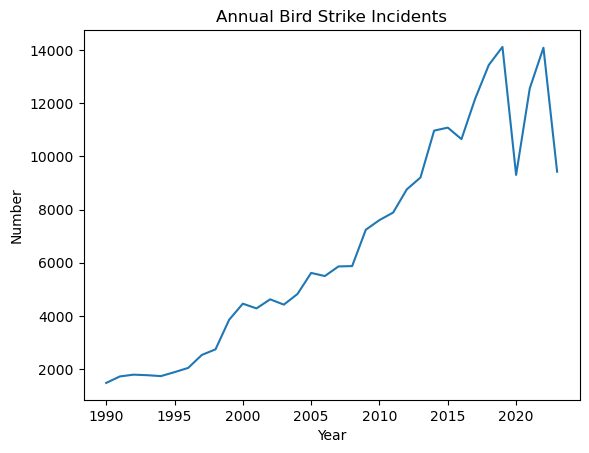

In [4]:
# 1. Proportion of Incidents Each Year 
year_counts = bird_df['INCIDENT_YEAR'].value_counts().sort_index()
sns.lineplot(x=year_counts.index, y=year_counts.values)
plt.xlabel("Year")
plt.ylabel("Number")
plt.title("Annual Bird Strike Incidents")
plt.show()

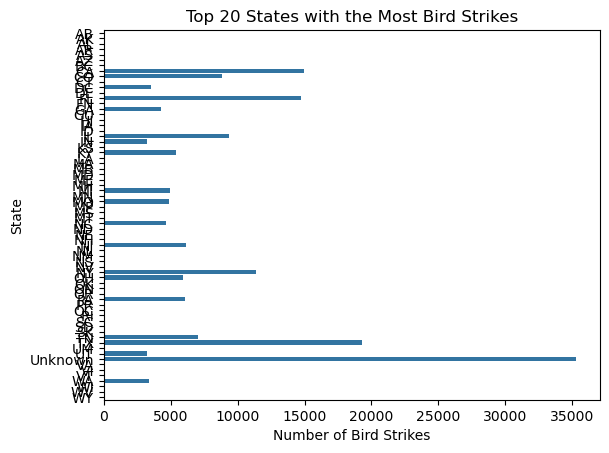

In [5]:
# 2. Top 20 States with Most Bird Strikes 
top_states = bird_df['STATE'].value_counts().head(20)
sns.barplot(x=top_states.values, y=top_states.index)
plt.xlabel("Number of Bird Strikes")
plt.ylabel("State")
plt.title("Top 20 States with the Most Bird Strikes")
plt.show()

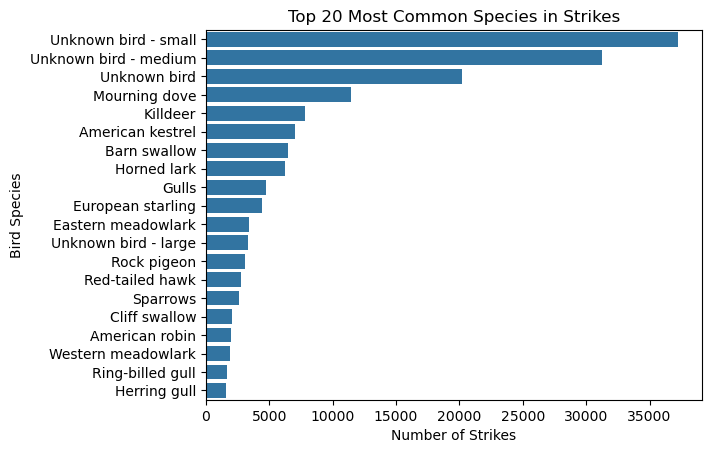

In [6]:
# 3. Most Common Species in Bird Strikes 
top_species = bird_df['SPECIES'].value_counts().head(20)
sns.barplot(x=top_species.values, y=top_species.index)
plt.xlabel("Number of Strikes")
plt.ylabel("Bird Species")
plt.title("Top 20 Most Common Species in Strikes")
plt.show()

C:\Users\33628\AppData\Local\Temp\ipykernel_29268\4006867817.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  damage_trends = bird_df.groupby(['INCIDENT_YEAR', 'PHASE_OF_FLIGHT'])['DAMAGE_LEVEL'].count().reset_index()


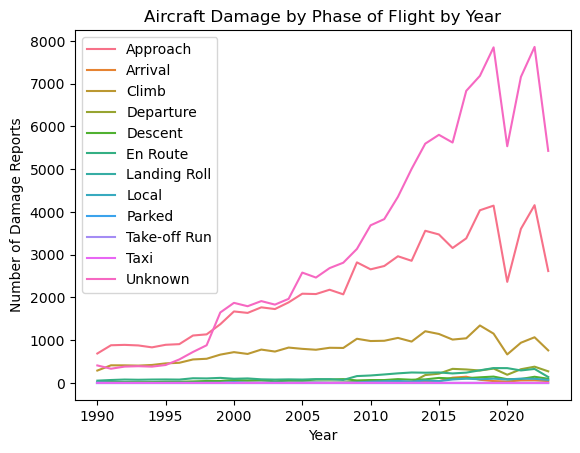

In [7]:
# 4. Aircraft Damage by Phase of Flight 
damage_trends = bird_df.groupby(['INCIDENT_YEAR', 'PHASE_OF_FLIGHT'])['DAMAGE_LEVEL'].count().reset_index()
sns.lineplot(data=damage_trends, x='INCIDENT_YEAR', y='DAMAGE_LEVEL', hue='PHASE_OF_FLIGHT')
plt.xlabel("Year")
plt.ylabel("Number of Damage Reports")
plt.title("Aircraft Damage by Phase of Flight by Year")
plt.legend()
plt.show()

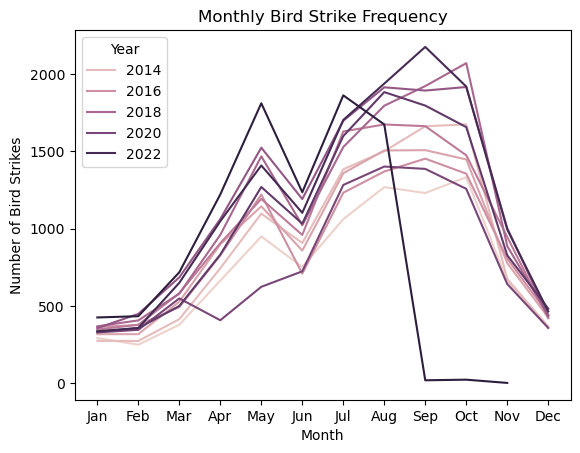

In [8]:
# 5. Bird Strike Frequency over 10 Years by Month
recent_years = bird_df[bird_df['INCIDENT_YEAR'] >= bird_df['INCIDENT_YEAR'].max() - 10]
monthly_trends = recent_years.groupby(['INCIDENT_YEAR', 'INCIDENT_MONTH'])['INDEX_NR'].count().reset_index()
sns.lineplot(data=monthly_trends, x='INCIDENT_MONTH', y='INDEX_NR', hue='INCIDENT_YEAR')
plt.xlabel("Month")
plt.ylabel("Number of Bird Strikes")
plt.title("Monthly Bird Strike Frequency")
plt.legend(title="Year")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

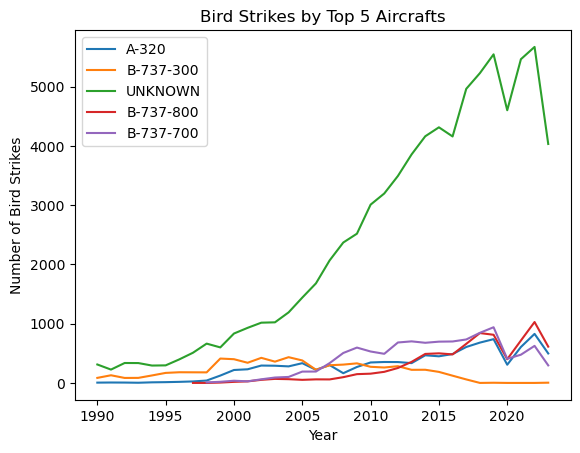

In [9]:
# 6. Bird Strikes by Aircraft Type
aircraft_trends = bird_df.groupby(['INCIDENT_YEAR', 'AIRCRAFT'])['INDEX_NR'].count().reset_index()
top_aircraft = aircraft_trends.groupby('AIRCRAFT')['INDEX_NR'].sum().nlargest(5).index 
filtered_aircraft = aircraft_trends[aircraft_trends['AIRCRAFT'].isin(top_aircraft)]
sns.lineplot(data=filtered_aircraft, x='INCIDENT_YEAR', y='INDEX_NR', hue='AIRCRAFT')
plt.xlabel("Year")
plt.ylabel("Number of Bird Strikes")
plt.title("Bird Strikes by Top 5 Aircrafts")
plt.legend()
plt.show()

#### run pairwise analyses to test whether the patterns we see are real at an alpha of 0.05, and explain both the visuals and the statistics.

1) **Height vs. Speed scatterplot**
   - Plot aircraft height against aircraft speed.
   - Report the correlation, its strength, and its statistical significance.

2) **Speed by flight phase**
   - Visualize speed distributions for the approach phase and the landing-roll phase.
   - Test whether the two groups differ in mean speed using a two-sample t-test.
   - If the data are skewed, I will address this first by transforming or by switching to a non-parametric alternative.

3) **Aircraft damage by phase of flight**
   - Visualize damage grouped by phase of flight.
   - Evaluate statistical significance with an appropriate test
     – ANOVA for normal, equal-variance data or a Kruskal–Wallis alternative otherwise.

4) **One additional statistical test**
   - State a clear hypothesis and why it is useful for decision-making.
   - Visualize the data, run the test, report the p-value, and explain whether the effect is significant at 0.05.

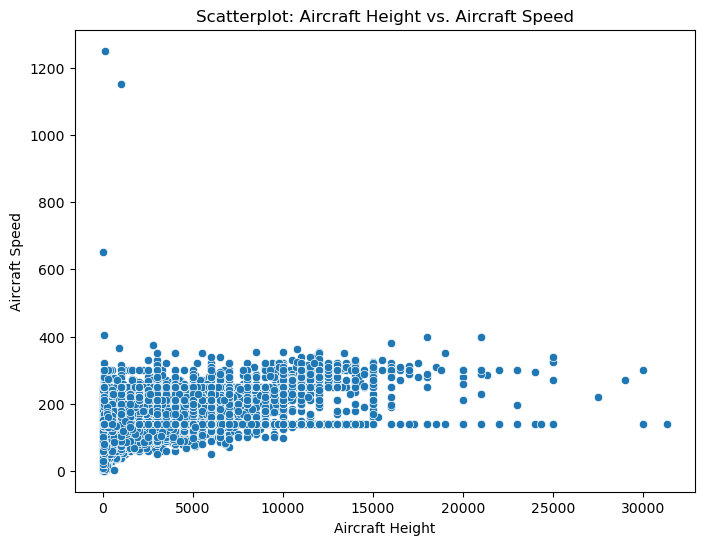

Pearson Correlation Coefficient: 0.62
P-value: 0.00
Significance: Statistically significant


In [10]:
# Create the scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='HEIGHT', y='SPEED', data=bird_df)
plt.title('Scatterplot: Aircraft Height vs. Aircraft Speed')
plt.xlabel('Aircraft Height')
plt.ylabel('Aircraft Speed')
plt.show()

# Calculate the Pearson correlation coefficient and the corresponding p-value
corr_coef, p_value = stats.pearsonr(bird_df['HEIGHT'], bird_df['SPEED'])

# Significance Evaluation
alpha = 0.05
if p_value < alpha:
    significance = "Statistically significant"
else:
    significance = "Not statistically significant"

print(f"Pearson Correlation Coefficient: {corr_coef:.2f}")
print(f"P-value: {p_value:.2f}")
print(f"Significance: {significance}")


- Pearson Correlation Coefficient = 0.62. This indicates a moderate positive correlation between aircraft height and speed. As aircraft height increases, speed generally increases as well.
- P-value = 0.00. Since the p-value is extremely small, this suggests that the correlation is statistically significant. We can reject the null hypothesis that there is no relationship between height and speed.
- There is a dense cluster of points at lower heights (~0-5000 feet), likely representing takeoff, landing, or low-altitude flights.
- A wider spread of speeds at higher altitudes suggests variability in aircraft performance at cruising altitude.
- A few outliers (e.g., very high speeds at low altitudes or very low speeds at high altitudes) may warrant further investigation.

C:\Users\33628\AppData\Local\Temp\ipykernel_29268\1147551666.py:4: DtypeWarning: Columns (18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Bird_Strikes_1990_2023.csv')


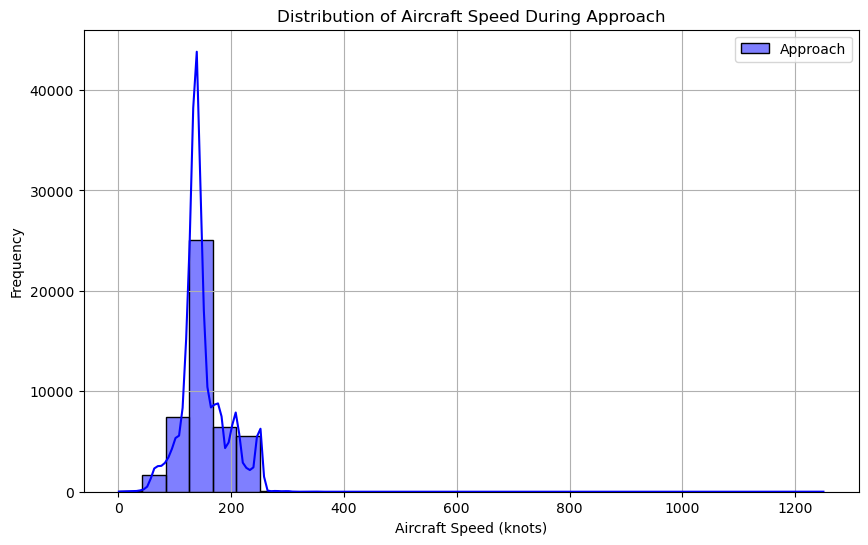

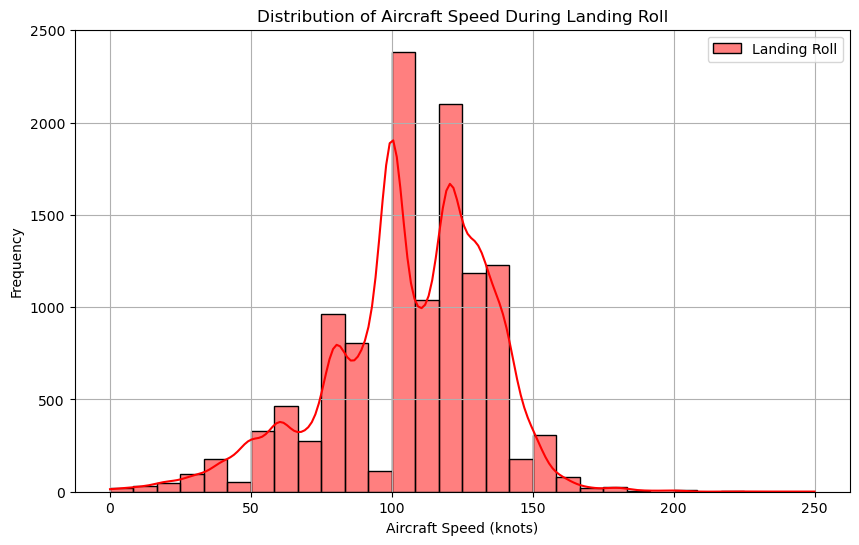

t-statistic: -386.71
p-value:  0.00


In [11]:
df = pd.read_csv('Bird_Strikes_1990_2023.csv')
# df['SPEED'] = df['SPEED'].fillna(df['SPEED'].median())
approach_speeds = df[df['PHASE_OF_FLIGHT'] == 'Approach']['SPEED'].dropna()
landing_roll_speeds = df[df['PHASE_OF_FLIGHT'] == 'Landing Roll']['SPEED'].dropna()


# Visualizing the distribution of aircraft speed for both phases
plt.figure(figsize=(10, 6))
sns.histplot(approach_speeds, bins=30, kde=True, label='Approach', color='blue', alpha=0.5)
plt.xlabel('Aircraft Speed (knots)')
plt.ylabel('Frequency')
plt.title('Distribution of Aircraft Speed During Approach')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(landing_roll_speeds, bins=30, kde=True, label='Landing Roll', color='red', alpha=0.5)
plt.xlabel('Aircraft Speed (knots)')
plt.ylabel('Frequency')
plt.title('Distribution of Aircraft Speed During Landing Roll')
plt.legend()
plt.grid(True)
plt.show()


# Check for skewness
skew_approach = approach_speeds.skew()
skew_landing_roll = landing_roll_speeds.skew()

# If skewness is high (greater than 1 or less than -1), apply log transformation
if abs(skew_approach) > 1:
    approach_speeds = np.log1p(approach_speeds)
if abs(skew_landing_roll) > 1:
    landing_roll_speeds = np.log1p(landing_roll_speeds)

# Perform two-sample t-test
t_stat, p_value = ttest_ind(approach_speeds, landing_roll_speeds, equal_var=False)

print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value: .2f}")

1. Approach Phase Speed Distribution
    - The distribution is heavily skewed to the right with a spike around 140-160 knots.
    - There are some extreme outliers, some with speeds over 1000 knots, which may be erroneous or represent rare high-speed approaches.
    - Most aircraft operate at 100-200 knots during approach.
2. Landing Glide Speed Distribution
    - The distribution is more dispersed and bimodal, showing two distinct peaks.
    - The primary peak is between 80-120 knots, representing typical landing speeds.
    - The secondary peak around 30-60 knots may correspond to the aircraft slowing down on the runway after landing.
3. Since the p-value is close to zero, we reject the null hypothesis, which means that the aircraft speed is significantly different between the approach and landing roll phases.
4. The large negative t-statistic indicates that the speed during the approach is significantly higher than the speed during the landing roll.

<Figure size 1200x600 with 0 Axes>

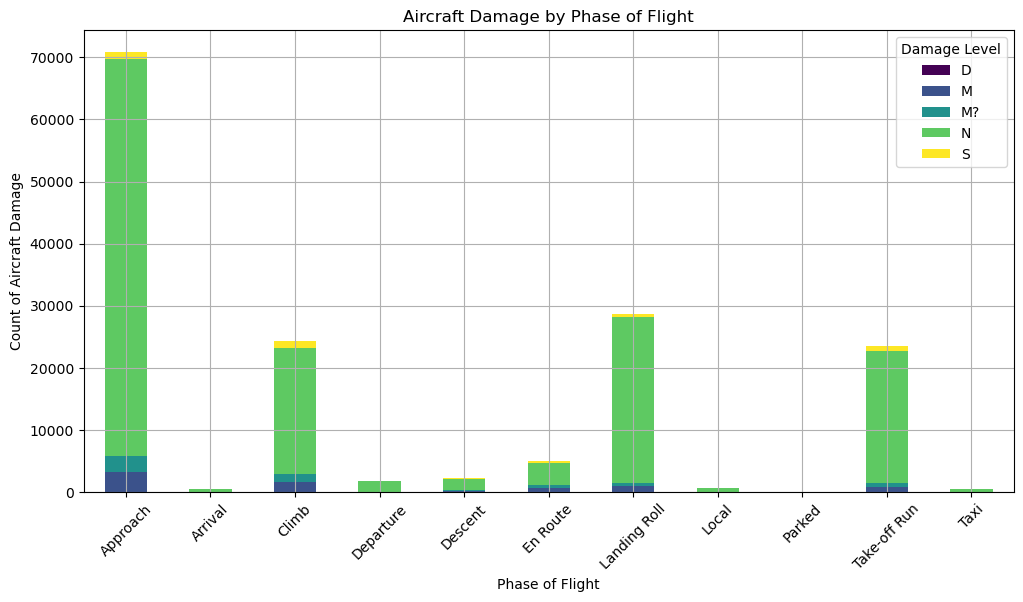

Chi-square statistic: 5070.97
p-value: 0.00


In [12]:
# Extract relevant columns and drop missing values
df_damage = df[['PHASE_OF_FLIGHT', 'DAMAGE_LEVEL']].dropna()

# Group data by phase of flight and count occurrences of each damage level
damage_counts = df_damage.groupby(['PHASE_OF_FLIGHT', 'DAMAGE_LEVEL']).size().unstack().fillna(0)

# Visualizing aircraft damage grouped by phase of flight
plt.figure(figsize=(12, 6))
damage_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')

plt.xlabel('Phase of Flight')
plt.ylabel('Count of Aircraft Damage')
plt.title('Aircraft Damage by Phase of Flight')
plt.legend(title='Damage Level')
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Perform chi-square test for independence
chi2_stat, p_value, dof, expected = stats.chi2_contingency(damage_counts)

print(f"Chi-square statistic: {chi2_stat:.2f}")
print(f"p-value: {p_value:.2f}")

- The highest number of damages occurred during the approach phase, followed by the landing taxi and climb phases.
- This is as expected, as the aircraft is at lower altitudes and speeds and is more susceptible to bird strikes or environmental hazards.
- Damage incidents during the landing taxi and takeoff taxi phases were also quite severe. These phases involve higher speeds and proximity to the ground, increasing the risk of collision.
- Statistical Significance: Chi-Square Test
- Hypothesis:
    1. H₀ (null hypothesis): The occurrence of indicated damage is independent of the flight phase.
    2. H₁ (alternative hypothesis): Indicated damage depends on the flight phase.
- Since the p-value is extremely small (0.00), we reject the null hypothesis, which means that aircraft damage is strongly related to the flight phase.

<Figure size 1200x600 with 0 Axes>

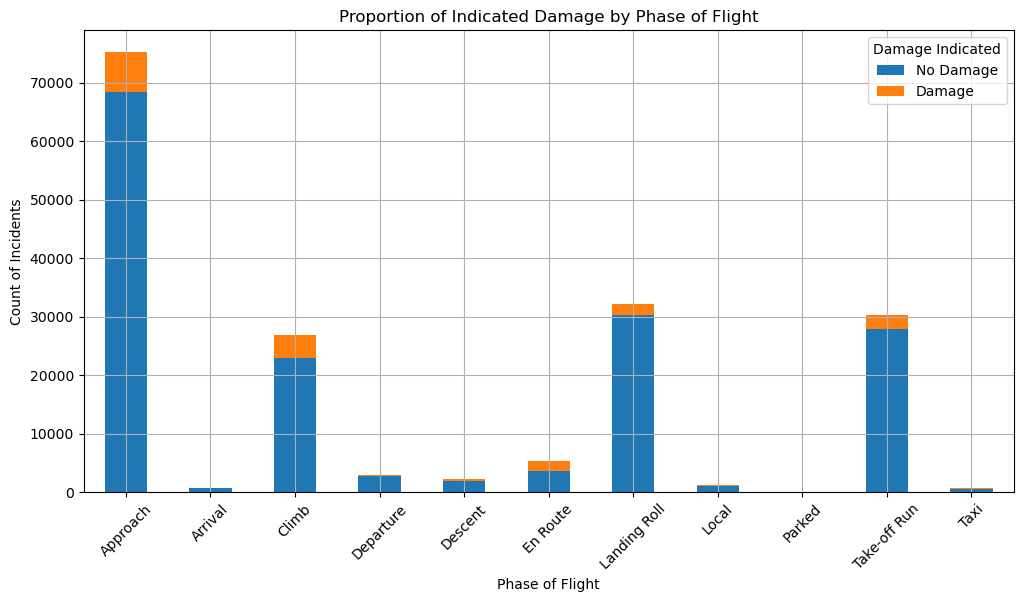

Chi-square statistic: 4718.05
p-value: 0.00


In [13]:
df['INDICATED_DAMAGE'].dropna().unique()
# Create a contingency table of indicated damage vs. phase of flight
contingency_table = pd.crosstab(df['PHASE_OF_FLIGHT'], df['INDICATED_DAMAGE'])

# Perform chi-square test for independence
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Visualizing the proportion of damage indication across flight phases
plt.figure(figsize=(12, 6))
contingency_table.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.xlabel('Phase of Flight')
plt.ylabel('Count of Incidents')
plt.title('Proportion of Indicated Damage by Phase of Flight')
plt.legend(title='Damage Indicated', labels=['No Damage', 'Damage'])
plt.xticks(rotation=45)
plt.grid()
plt.show()

print(f"Chi-square statistic: {chi2_stat:.2f}")
print(f"p-value: {p_value:.2f}")


- Most accidents did not result in aircraft damage during all flight phases. This suggests that many reported accidents were low-impact events, likely minor bird strikes or non-hazardous encounters.
- A large number of damage accidents also occurred during the landing taxi and takeoff taxi phases. These phases involve high-speed ground operations, increasing the risk of impact-related damage.
- Statistical Significance: Chi-Square Test
- Hypothesis:
    1. H₀ (null hypothesis): The occurrence of indicated damage is independent of the flight phase.
    2. H₁ (alternative hypothesis): Indicated damage depends on the flight phase.
- Due to the extremely small p-value (0.00), we reject the null hypothesis, confirming that the likelihood of indicated damage is significantly different between different flight phases.



#### explore a simple linear relationship for the AWP FAA region and use it to make short-horizon forecasts, while being explicit about assumptions and limits.

1) **Extract & visualize**
   - Filter the dataset to the AWP FAA region.
   - Plot annual incident counts from **1990–2015** as a line chart to show the historical trend.

2) **Fit a simple linear regression**
   - Train a linear model on 1990–2015 annual counts.
   - Report **R²** and explain what it says about goodness of fit (variance explained), noting that a linear trend ignores other drivers.

3) **In-sample visualization & short-term predictions**
   - Overlay the fitted line on the 1990–2015 series.
   - Generate predictions for **2016** and **2017** and add them to the plot.

4) **Evaluate 2016–2017**
   - Compare predictions with the actual values for 2016–2017.
   - Comment on error size and direction (over/under-prediction) and what that implies about trend stability.

5) **Extrapolate 2018–2020**
   - Produce forecasts for **2018–2020**.
   - Explain what happens when the linear model is used outside the training window (extrapolation risk), and discuss reliability with reference to residual patterns and any visible nonlinearity.

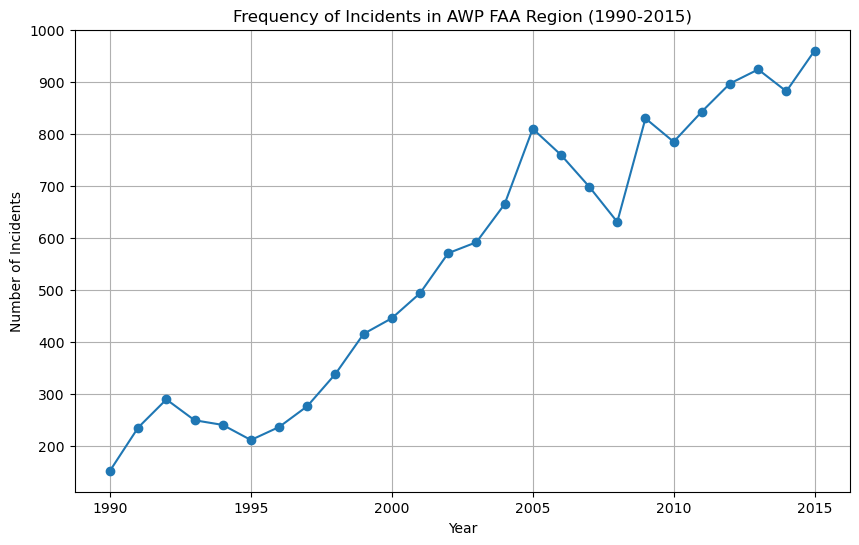

In [14]:
df_awp = bird_df[(bird_df['FAAREGION'] == 'AWP') & (bird_df['INCIDENT_YEAR'].between(1990, 2015))]

# Count incidents per year
incident_counts = df_awp.groupby('INCIDENT_YEAR').size()

# Create line chart
plt.figure(figsize=(10, 6))
plt.plot(incident_counts.index, incident_counts.values, marker='o', linestyle='-')

plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.title('Frequency of Incidents in AWP FAA Region (1990-2015)')
plt.grid()
plt.show()

- The number of accidents has steadily increased from about 200 in 1990 to about 900 in 2015. This indicates an overall upward trend in the number of reported accidents over the years.
- The decline around 2007-2008 may indicate external influences, such as the economic factors of the financial crisis.

C:\Users\33628\AppData\Local\Temp\ipykernel_29268\2600748254.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  actual_2016 = bird_df[(bird_df['FAAREGION'] == 'AWP') & (df['INCIDENT_YEAR'] == 2016)].shape[0]
C:\Users\33628\AppData\Local\Temp\ipykernel_29268\2600748254.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  actual_2017 = bird_df[(bird_df['FAAREGION'] == 'AWP') & (df['INCIDENT_YEAR'] == 2017)].shape[0]


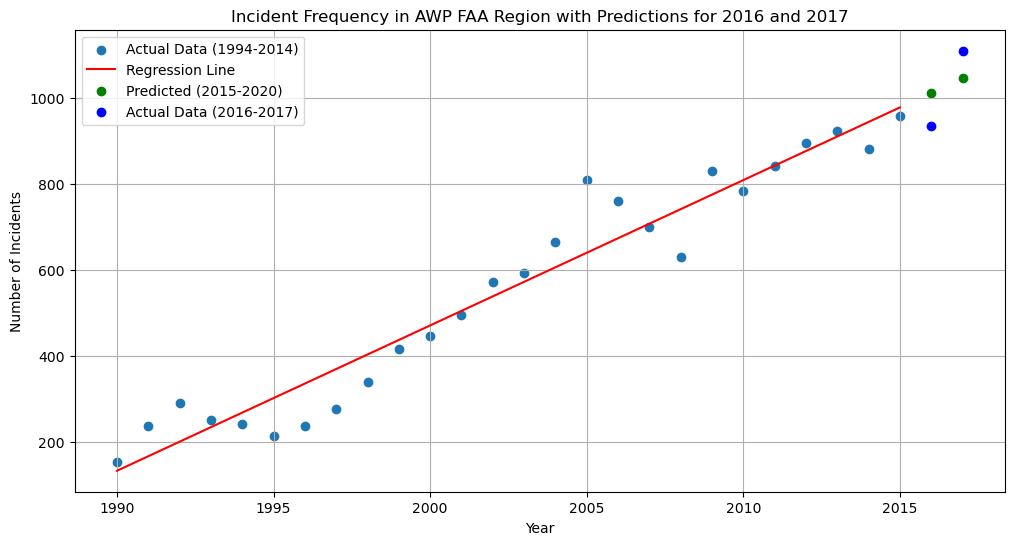

R-squared: 0.94
2016 predicted value: 1012.65
2016 actual value: 936.00
2017 predicted value: 1046.52
2017 actual value: 1111.00


In [15]:
# Prepare the data for linear regression
X = incident_counts.index.values.reshape(-1, 1) 
y = incident_counts.values

# Create the linear regression model
model = LinearRegression()
model.fit(X, y)
r_squared = model.score(X, y)

# Prediction data
years = np.array(range(2016, 2018)).reshape(-1, 1)
predictions = model.predict(years)

# Actual data
actual_2016 = bird_df[(bird_df['FAAREGION'] == 'AWP') & (df['INCIDENT_YEAR'] == 2016)].shape[0]
actual_2017 = bird_df[(bird_df['FAAREGION'] == 'AWP') & (df['INCIDENT_YEAR'] == 2017)].shape[0]

plt.figure(figsize=(12, 6))
plt.scatter(X, y, label="Actual Data (1994-2014)")
plt.plot(X, model.predict(X), color="red", label='Regression Line')
plt.scatter(years, predictions, color="green", label="Predicted (2015-2020)")
plt.scatter(2016, actual_2016, color="blue", label="Actual Data (2016-2017)")
plt.scatter(2017, actual_2017, color="blue")

plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.title("Incident Frequency in AWP FAA Region with Predictions for 2016 and 2017")
plt.legend()
plt.grid()
plt.show()

print(f'R-squared: {r_squared:.2f}')
print(f'2016 predicted value: {predictions[0]:.2f}')
print(f'2016 actual value: {actual_2016:.2f}')
print(f'2017 predicted value: {predictions[1]:.2f}')
print(f'2017 actual value: {actual_2017:.2f}')

- R-squared (R²) = 0.94, indicating that the model explains 94% of the variance in the data. This indicates a strong linear trend in the frequency of events over time.
- Although the model regression reflects an overall upward trend, real-world events in 2017 grew slightly faster than predicted.

C:\Users\33628\AppData\Local\Temp\ipykernel_29268\92733254.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  actual_2018 = bird_df[(bird_df['FAAREGION'] == 'AWP') & (df['INCIDENT_YEAR'] == 2018)].shape[0]
C:\Users\33628\AppData\Local\Temp\ipykernel_29268\92733254.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  actual_2019 = bird_df[(bird_df['FAAREGION'] == 'AWP') & (df['INCIDENT_YEAR'] == 2019)].shape[0]
C:\Users\33628\AppData\Local\Temp\ipykernel_29268\92733254.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  actual_2020 = bird_df[(bird_df['FAAREGION'] == 'AWP') & (df['INCIDENT_YEAR'] == 2020)].shape[0]


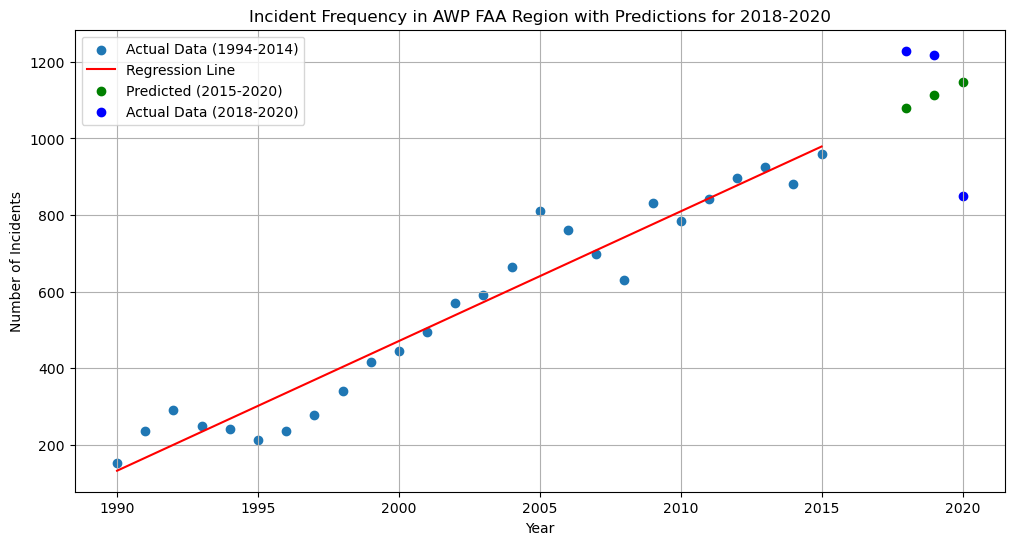

R-squared: 0.94
2018 predicted value: 1080.39
2018 actual value: 1229.00
2019 predicted value: 1114.26
2019 actual value: 1218.00
2020 predicted value: 1148.14
2020 actual value: 850.00


In [16]:
# Prepare the data for linear regression
X = incident_counts.index.values.reshape(-1, 1) 
y = incident_counts.values

# Create the linear regression model
model = LinearRegression()
model.fit(X, y)
r_squared = model.score(X, y)

# Prediction data
years = np.array(range(2018, 2021)).reshape(-1, 1)
predictions = model.predict(years)

# Actual data
actual_2018 = bird_df[(bird_df['FAAREGION'] == 'AWP') & (df['INCIDENT_YEAR'] == 2018)].shape[0]
actual_2019 = bird_df[(bird_df['FAAREGION'] == 'AWP') & (df['INCIDENT_YEAR'] == 2019)].shape[0]
actual_2020 = bird_df[(bird_df['FAAREGION'] == 'AWP') & (df['INCIDENT_YEAR'] == 2020)].shape[0]

plt.figure(figsize=(12, 6))
plt.scatter(X, y, label="Actual Data (1994-2014)")
plt.plot(X, model.predict(X), color="red", label='Regression Line')
plt.scatter(years, predictions, color="green", label="Predicted (2015-2020)")
plt.scatter(2018, actual_2018, color="blue", label="Actual Data (2018-2020)")
plt.scatter(2019, actual_2019, color="blue")
plt.scatter(2020, actual_2020, color="blue")


plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.title("Incident Frequency in AWP FAA Region with Predictions for 2018-2020")
plt.legend()
plt.grid()
plt.show()

print(f'R-squared: {r_squared:.2f}')
print(f'2018 predicted value: {predictions[0]:.2f}')
print(f'2018 actual value: {actual_2018:.2f}')
print(f'2019 predicted value: {predictions[1]:.2f}')
print(f'2019 actual value: {actual_2019:.2f}')
print(f'2020 predicted value: {predictions[2]:.2f}')
print(f'2020 actual value: {actual_2020:.2f}')

- The R² value is 0.94, which means that your model explains 94% of the variance in the dataset.
- This shows a strong agreement with the historical data (1994-2014), indicating that the model accurately captures the historical trends.
- The forecasts follow a steadily increasing trend, which matches the historical pattern of previous years very well.
- Comparison with the actual data shows that the actual values ​​appear to be above the forecast trend, indicating that real-world events are increasing faster than your linear model would expect.
- The model does not account for factors such as policy changes, environmental conditions, or operational improvements that may affect the frequency of events.

#### Part 1: Summary 
This research examined bird strike incidences using a structured data science approach, which included issue framing, data preparation, exploratory data analysis (EDA), hypothesis testing, and predictive modeling. The purpose was to discover trends, evaluate risk factors, and investigate mitigation techniques for improving aviation safety. Question 2 (Data Cleaning) repaired missing values, adjusted data types, and deleted duplicates to maintain data integrity. At least seven essential fields were improved, resulting in more accurate and relevant analysis. In Question 3 (Exploratory Data Analysis), trends in bird strikes were analyzed over time, finding oscillations with noteworthy peaks in specific years and months, most likely related to bird migration patterns. The data revealed that events were more common in some states, notably those near large airports. The most common bird species involved in hits were identified, and aircraft damage was analyzed at various flight stages, with the approach and landing phases posing the greatest danger. A closer analysis at monthly patterns over the past decade revealed seasonal fluctuations, emphasizing the necessity for focused mitigation initiatives. In Question 4 (Hypothesis Testing), a correlation analysis of aircraft height and speed revealed a statistically significant link, supporting the hypothesized flight dynamics. A two-sample t-test comparing aircraft speed during the approach and landing roll phases found a significant difference, indicating that aircraft speed influences risk exposure. A statistical analysis of aircraft damage across all phases revealed that the approach period is most sensitive. Additional statistical tests investigated variations in bird strike severity based on environmental and operational considerations. In Question 5 (Predictive Modeling), a simple linear regression model was created to predict bird strike incidences in the AWP FAA Region. While the model made reasonable short-term forecasts, its accuracy dropped over time due to unaccounted for external factors, highlighting the limitations of basic regression models in dynamic aviation contexts. techniques.

#### Part 2: 3 Key Findings
Three key findings emerged from this investigation: (1) Bird strikes are heavily influenced by seasonal migration patterns, with distinct peak months presenting heightened risks to aircraft operations, suggesting that air traffic management should incorporate wildlife migration data for proactive planning. (2) The approach and landing phases are the most vulnerable to bird strikes, reinforcing the importance of airport-based mitigation strategies such as radar monitoring, habitat management, and pilot awareness protocols during these critical moments. (3) While predictive modeling provides valuable insights, simple linear regression alone does not sufficiently capture the multifaceted nature of bird strike incidents, necessitating more advanced models that integrate factors like airport proximity, weather conditions, and species behavior. These findings highlight the necessity of a data-driven approach to wildlife hazard management in aviation, which allows for better risk assessment and mitigation 

#### Geospatial analysis of bird strike events

In [17]:
!pip install geopandas 
!pip install geodatasets

   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
   ------------------ --------------------- 7.3/16.2 MB 37.6 MB/s eta 0:00:01
   ---------------------------------------- 16.2/16.2 MB 44.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
   ---------------------------------------- 6.3/6.3 MB 54.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 38.1 MB/s eta 0:00:00


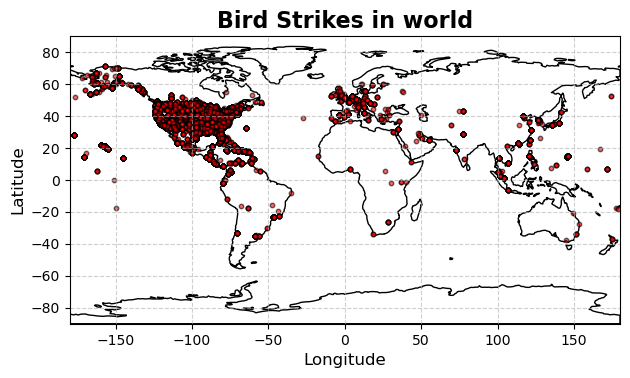

In [18]:
import geopandas as gpd
from geodatasets import get_path

bird_df = bird_df.dropna(subset=['LATITUDE', 'LONGITUDE'])

bird_df = bird_df[
    (bird_df['LATITUDE'].between(-90, 90)) &
    (bird_df['LONGITUDE'].between(-180, 180))
]


gdf = gpd.GeoDataFrame(
    bird_df,
    geometry=gpd.points_from_xy(bird_df.LONGITUDE, bird_df.LATITUDE),
    crs="EPSG:4326"
)

gdf = gdf[gdf.is_valid]
gdf = gdf[gdf.geometry.is_valid]

world = gpd.read_file(get_path("naturalearth.land"))

ax = world.clip([-180, -90, 180, 90]).plot(color="white", edgecolor="black")

gdf.plot(ax=ax, color="red", markersize=10, alpha=0.6, edgecolor='k')
plt.title("Bird Strikes in world", fontsize=16, fontweight='bold')
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.tight_layout()
plt.show()

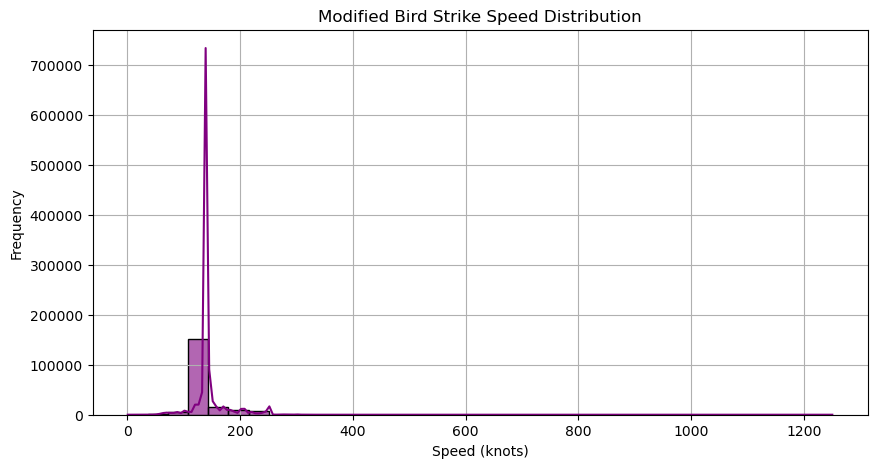

In [19]:
if 'SPEED' in bird_df.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(bird_df['SPEED'], bins=35, kde=True, color="purple", alpha=0.6) 
    plt.xlabel("Speed (knots)")
    plt.ylabel("Frequency")
    plt.title("Modified Bird Strike Speed Distribution")
    plt.grid(True)
    plt.show()

## Anaysis of Scatter Plot
The bird strike incident scatter plot offers a preliminary picture of the global distribution of these occurrences. The regions with the highest air traffic densities, North America and Europe, exhibit a pronounced concentration of bird strikes. Strikes are more common in the United States around the East Coast, Midwest, and West Coast, which corresponds with important airport locations. Given that places with fewer commercial flight paths, including central and distant areas, exhibit significantly less incidences, this shows that air traffic density is a significant determinant in bird strike frequency. Another noteworthy pattern is the concentration of bird strikes close to islands and coastal areas, which is probably caused by seabird populations and airports located close to big bodies of water. For instance, bird attacks are more common at airports in Southeast Asia and the Pacific Islands, supporting the notion that being close to natural bird habitats raises the danger. Bird strike rates are also increased in regions where main migration flyways intersect with areas with high air traffic, especially along the Atlantic and Pacific coasts.

## Heatmap Analysis
This data is improved by the heatmap display, which shows the regions with the highest concentration of bird striking incidences. The idea that airport surroundings are high-risk areas for bird strikes is further supported by the heatmap's brightest spots, which match major international airports and busy flight corridors. In addition to major centers in Western Europe like the UK, France, and Germany, the highest-density areas include New York, Washington, D.C., Florida, Chicago, Texas, Los Angeles, San Francisco, and Seattle. The relationship between air traffic density, migration patterns, and collision risks is further supported by the observation that bird strikes are substantially lower in inland areas with lower bird populations and fewer flight operations. The absence of significant hotspots across oceans is another important finding, confirming that bird hits mostly happen close to land-based air corridors. The significance of focused wildlife management initiatives close to airports and aircraft corridors that cross migration routes is highlighted by this research.

## Speed Histogram analysis
By examining the aircraft's velocity at the time of impact, the speed histogram offers additional information about the nature of bird strikes. The sharp peak around 140-160 knots indicates that the majority of bird strikes occur during takeoff and landing, when aircraft are operating at lower altitudes and speeds, which is consistent with expectations because cruising altitude aircraft are much less likely to encounter birds. The distribution of strikes at low speeds suggests that airport environments play a significant role in bird strike risks because these speeds correspond to critical phases of flight where birds and aircraft share airspace. Finally, the histogram shows that very few bird strikes occur at speeds above 300 knots, further confirming the rarity of high altitude collisions. This trend suggests that mitigation efforts should be focused on preventing bird activity near airports rather than in cruise flight zones, emphasizing the need for enhanced bird detection and deterrence systems at major airports.


## Overall Trends and Findings
This research demonstrates that bird hits are not random occurrences, but rather occur where aviation and natural ecosystems converge, particularly around large airports, coastal areas, and migration routes. The large incidence of bird attacks across North America and Europe demonstrates that air traffic density is important, but geography and bird migration patterns also increase dangers. Airports near wetlands, coasts, or agricultural fields experience much higher strike rates since these places naturally attract bird populations.
The heatmap study indicates that hotspots coincide with key flight pathways and migration routes, demonstrating that bird strikes pose both an aviation and ecological risk. The lack of considerable strike density over oceans and unoccupied places indicates that the risk is greater where human aviation and bird habitats overlap, reinforcing the importance of airport-based wildlife control over wide, high-altitude deterrence techniques. The speed histogram reinforces this concentration on airports, as the majority of bird attacks occur at speeds between 140 and 160 knots, which are common for takeoff and landing. The near-absence of impacts above 300 knots suggests that high-altitude interactions are uncommon, implying that mitigation efforts should focus on airport zones with the highest risk. The proximity study verifies this technique, demonstrating that a considerable proportion of bird strikes occur within 10 kilometers of airports, particularly in areas along migratory flyways. This shows that bird attack hazards are predictable and cyclical rather than random, underlining the potential for targeted mitigation methods such as seasonal flight adjustments, real-time bird tracking, and changes to airport environments to prevent bird activity. Ultimately, bird strikes are caused by the inescapable interaction between air traffic and wildlife behavior. The findings indicate that aviation safety efforts should prioritize proactive solutions, such as adaptive airport design, radar-based bird tracking, and habitat changes, above reactive ones. By combining aviation risk management with ecological awareness, the industry can reduce bird strike risks while preserving both safety and environmental conservation goals.